In [4]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(["seaborn-darkgrid"])
plt.rcParams["figure.figsize"] = (12, 9)
plt.rcParams["font.family"] = "DejaVu Sans"

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [5]:
PATH_TO_SAMSUNG_DATA = r"C:\Users\mi\MLcourse\mlcourse.ai\data\samsung_HAR"

In [7]:
X_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "samsung_train.txt"))
y_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "samsung_train_labels.txt")).astype(int)

X_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "samsung_test.txt"))
y_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "samsung_test_labels.txt")).astype(int)

In [11]:
# Checking dimensions
assert X_train.shape == (7352, 561) and y_train.shape == (7352,)
assert X_test.shape == (2947, 561) and y_test.shape == (2947,)

In [12]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

Define the number of unique values of the labels of the target class.

In [15]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [16]:
n_classes = np.unique(y).size

Scale the sample using StandardScaler with default parameters.

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Reduce the number of dimensions using PCA, leaving as many components as necessary to explain at least 90% of the variance of the original (scaled) data. Use the scaled dataset and fix random_state (RANDOM_STATE constant).

In [18]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

Question 1:
What is the minimum number of principal components required to cover the 90% of the variance of the original (scaled) data?

In [19]:
X_pca.shape

(10299, 65)

Question 2:
What percentage of the variance is covered by the first principal component? Round to the nearest percent.

In [20]:
round(float(pca.explained_variance_ratio_[0] * 100))

51

Visualize the data in the projection on the first two main components.

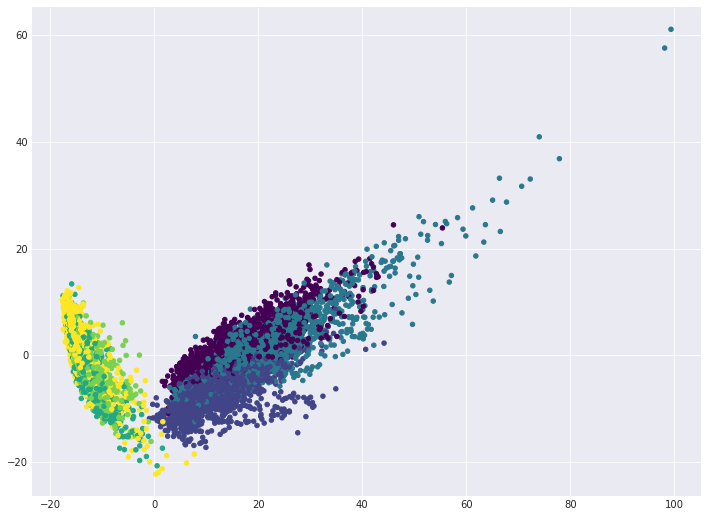

In [21]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis');

Run the data clustering using the KMeans method, training the model on data with a reduced PCA dimension. In this case, we will give a clue to look for exactly 6 clusters, but in general case we will not know how many clusters we should be searching.

Options: \
n_clusters = n_classes (number of unique labels of the target class) \
n_init = 100 \
random_state = RANDOM_STATE (for the reproducibility of the result)

Other parameters should have default values.

In [24]:
kmeans = KMeans(n_clusters = n_classes, n_init = 100, random_state = RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

Visualize data in projection on the first two principal components. Color the dots according to the clusters obtained.

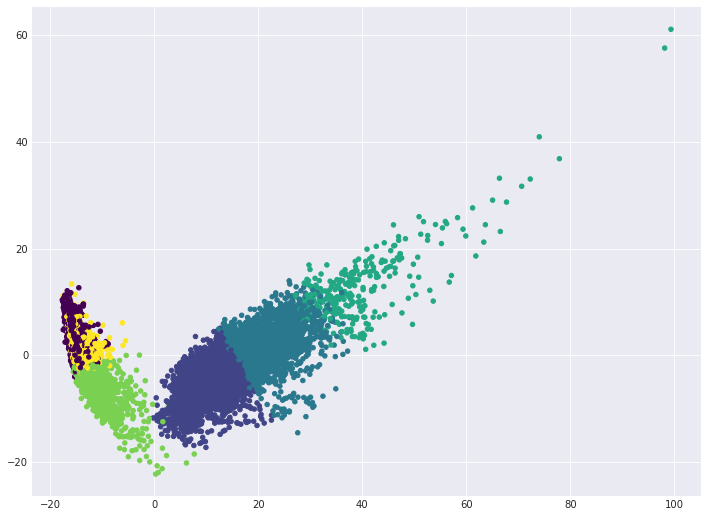

In [25]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis');

Look at the correspondence between the cluster marks and the original class labels and what kinds of activities the KMeans algorithm is confused at.

In [26]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['walking', 'going up the stairs',
            'going down the stairs', 'sitting', 'standing', 'lying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab


,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,0,904,740,78,0,0,1722
going up the stairs,0,1242,295,5,2,0,1544
going down the stairs,0,320,890,196,0,0,1406
sitting,91,1,0,0,450,1235,1777
standing,0,0,0,0,562,1344,1906
lying,1558,5,0,0,329,52,1944
all,1649,2472,1925,279,1343,2631,10299


We see that for each class (i.e., each activity) there are several clusters. Let's look at the maximum percentage of objects in a class that are assigned to a single cluster. This will be a simple metric that characterizes how easily the class is separated from others when clustering.

Example: if for class "walking downstairs" (with 1406 instances belonging to it), the distribution of clusters is:

cluster 1 - 900 \
cluster 3 - 500 \
cluster 6 - 6, \
then such a share will be 900/1406 ≈ 0.64.

Question 4:
Which activity is separated from the rest better than others based on the simple metric described above?

In [27]:
pd.Series(tab.iloc[:-1,:-1].max(axis=1).values / 
          tab.iloc[:-1,-1].values, index=tab.index[:-1])

walking                  0.524971
going up the stairs      0.804404
going down the stairs    0.633001
sitting                  0.694992
standing                 0.705142
lying                    0.801440
dtype: float64

It can be seen that kMeans does not distinguish activities very well. Use the elbow method to select the optimal number of clusters. Parameters of the algorithm and the data we use are the same as before, we change only n_clusters.

In [28]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, 
                    random_state=RANDOM_STATE, n_jobs=1).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

<ipython-input-28-0bf4303e6803>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


C:\Programming\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Programming\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Programming\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Programming\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Programming\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning:

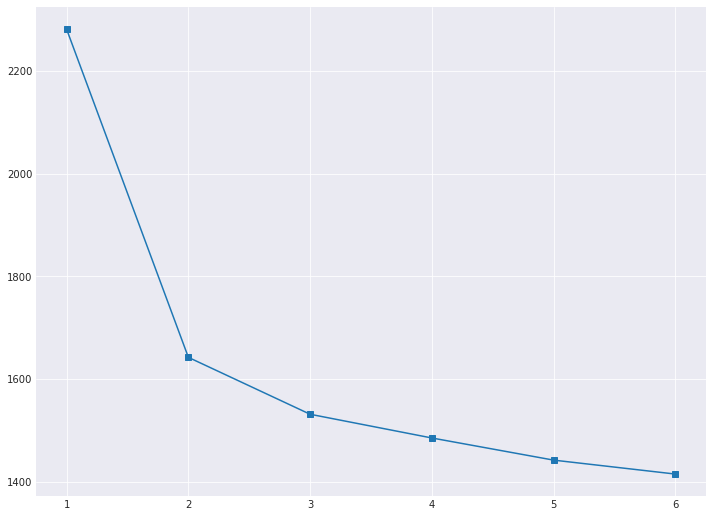

In [29]:
plt.plot(range(1, 7), inertia, marker='s');

Question 5:
How many clusters can we choose according to the elbow method?

In [30]:
2

2

Let's try another clustering algorithm, described in the article – agglomerative clustering.

In [32]:
ag = AgglomerativeClustering(n_clusters=n_classes, linkage='ward').fit(X_pca)

Calculate the Adjusted Rand Index (sklearn.metrics) for the resulting clustering and for KMeans with the parameters from the 4th question.

In [34]:
print('KMeans: ARI =', metrics.adjusted_rand_score(y, cluster_labels))
print('Agglomerative CLustering: ARI =', metrics.adjusted_rand_score(y, ag.labels_))

KMeans: ARI = 0.4199036333641994
Agglomerative CLustering: ARI = 0.49362763373004886


You can notice that the task is not very well solved when we try to detect several clusters (> 2). Now, let's solve the classification problem, given that the data is labeled.

For classification, use the support vector machine – class sklearn.svm.LinearSVC. In this course, we didn't study this algorithm separately, but it is well-known and you can read about it, for example here.

Choose the C hyperparameter forLinearSVC using GridSearchCV.

Train the new StandardScaler on the training set (with all original features), apply scaling to the test set \
In GridSearchCV, specify cv = 3.

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [38]:
%%time
# Your code here
best_svc = GridSearchCV(svc, svc_params, n_jobs=1, cv=3, verbose=1)
best_svc.fit(X_train_scaled, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Programming\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Programming\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Programming\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Programming\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Programming\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: Converg

Wall time: 42.2 s


C:\Programming\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=3, estimator=LinearSVC(random_state=17), n_jobs=1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, verbose=1)

In [39]:
best_svc.best_params_, best_svc.best_score_

({'C': 0.1}, 0.9382506099134881)

In [40]:
y_predicted = best_svc.predict(X_test_scaled)

In [41]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'lying', 'all']
tab.columns = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'lying', 'all']
tab

,walking,climbing up the stairs,going down the stairs,sitting,standing,lying,all
walking,494,2,0,0,0,0,496
climbing up the stairs,12,459,0,0,0,0,471
going down the stairs,2,3,414,1,0,0,420
sitting,0,4,0,426,61,0,491
standing,0,0,0,15,517,0,532
lying,0,0,0,0,11,526,537
all,508,468,414,442,589,526,2947


Finally, do the same thing as in Question 7, but add PCA.

Use X_train_scaled andX_test_scaled \
Train the same PCA as before, on the scaled training set, apply scaling to the test set \
Choose the hyperparameter C via cross-validation on the training set with PCA-transformation. You will notice how much faster it works now.


Question 9:
What is the difference between the best quality (accuracy) for cross-validation in the case of all 561 initial characteristics and in the second case, when the principal component method was applied? Round to the nearest percent.

In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [43]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [44]:
%%time
best_svc_pca = GridSearchCV(svc, svc_params, n_jobs=1, cv=3, verbose=1)
best_svc_pca.fit(X_train_pca, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Programming\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Programming\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Programming\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Programming\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Programming\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: Converg

Wall time: 10.4 s


C:\Programming\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=3, estimator=LinearSVC(random_state=17), n_jobs=1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, verbose=1)

In [45]:
best_svc_pca.best_params_, best_svc_pca.best_score_

({'C': 1}, 0.8998943094169531)

In [46]:
round(100 * (best_svc_pca.best_score_ - best_svc.best_score_))

-4.0